#Lecture 7: Fast sparse solvers

##Sparse matrix 

 **DEF:** Sparse matrix is a matrix that contains $\mathcal{O}(n)$ nonzero elements.


###Sparse matrices are ubiquitous in PDE

Consider for example 3D Poisson equation:



$$\Delta T = \frac{\partial^2T}{\partial x^2}+\frac{\partial^2T}{\partial y^2}+\frac{\partial^2T}{\partial z^2}=f.$$


After discretization we obtain matrix five diagonal matrix A:

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import matplotlib.cm as cm
%matplotlib inline
N = 3
B = np.diag(2*np.ones(N))  + np.diag((-1)*np.ones(N-1),k=-1)+ np.diag((-1)*np.ones(N-1),k = 1)
Id = np.diag(np.ones(N));
# Making 2D operator:
A = np.kron(Id,np.kron(Id,B)) + np.kron(Id,np.kron(B,Id)) +np.kron(B,np.kron(Id,Id))

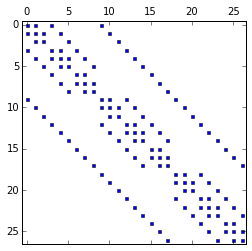

In [10]:

plt.spy(A,markersize=34/N**2)

 that matrix has $\mathcal{O}(1)$ elements in a row, therefore it is sparse.

Finite elements method is also likely to give you system with sparse matrix.

##How to store a sparse matrix

### Coordinate format

**(i, j, value)**

i.e. store two integer arrays and one real array.
**Easy** to add elements.
But how to multiply a matrix by vector?

###CSR format

A matrix is stored as 3 different arrays:

  **sa, ja, ia**

where:

* **nnz** is the total number of non-zeros for the matrix
* **sa** is an real-value array of non-zeros for the matrix (length nnz)
* **ja** is an integer array of  column number of the non-zeros (length nnz)
* **ia** is an integer array of locations of the first non-zero element in each row (length n+1)


(Blackboard figure)
###Idea behind CSR.
* For each row i we store the column number of the non-zeros (and their) values
* We stack this all together into ja and sa arrays
* We save the location of the first non-zero element in each row

###CSR helps for matrix-by-vector product as well
```
   for i in xrange(n):
       for k in xrange(ia(i):ia(i+1)-1):
           y(i) += sa(k) * x(ja(k))
```
Let us do a short timing test

In [26]:
import numpy as np
import scipy as sp
import scipy.sparse
import scipy.sparse.linalg
from scipy.sparse import csc_matrix, csr_matrix, coo_matrix, lil_matrix
 
A = csr_matrix([10,10])
B = lil_matrix([10,10])
A[0,0] = 1
#print A
B[0,0] = 1
#print B



In [44]:
import numpy as np
import scipy as sp
import scipy.sparse
import scipy.sparse.linalg
from scipy.sparse import csc_matrix, csr_matrix, coo_matrix
import matplotlib.pyplot as plt
import time
%matplotlib inline
n = 1000
ex = np.ones(n);
lp1 = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
e = sp.sparse.eye(n)
A = sp.sparse.kron(lp1, e) + sp.sparse.kron(e, lp1)
A = csr_matrix(A)
rhs = np.ones(n * n)
B = coo_matrix(A)
#t0 = time.time()
%timeit A.dot(rhs)
#print time.time() - t0
#t0 = time.time()
%timeit B.dot(rhs)
#print time.time() - t0

100 loops, best of 3: 10.5 ms per loop
100 loops, best of 3: 14 ms per loop


As you see, CSR is faster, and for more unstructured patterns the gain will be larger. 

CSR format has difficulties with adding new elements.

##How to solve linear systems?



###Direct or iterative solvers



###Direct solvers

The direct methods use **sparse Gaussian elimination**, i.e.
they eliminate variables while trying to keep the matrix as sparse as possible. 

And often, the inverse of a sparse matrix is not 
sparse:


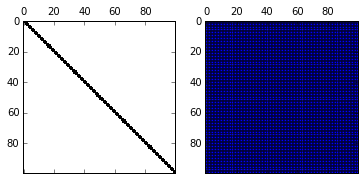

In [63]:
N = n = 100
ex = np.ones(n);
a = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
a = a.todense()
b = np.array(np.linalg.inv(a))
fig,axes = plt.subplots(1, 2)
axes[0].spy(a)
axes[1].spy(b,markersize=2)

Looks woefully.

In [65]:
N = n = 5
ex = np.ones(n);
A = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
A = A.todense()
B = np.array(np.linalg.inv(A))

print B

[[-0.83333333 -0.66666667 -0.5        -0.33333333 -0.16666667]
 [-0.66666667 -1.33333333 -1.         -0.66666667 -0.33333333]
 [-0.5        -1.         -1.5        -1.         -0.5       ]
 [-0.33333333 -0.66666667 -1.         -1.33333333 -0.66666667]
 [-0.16666667 -0.33333333 -0.5        -0.66666667 -0.83333333]]


But occasionally L and U factors can be sparse.

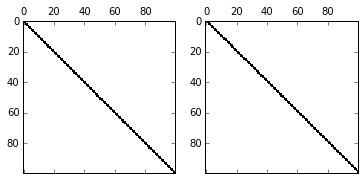

In [57]:
p, l, u = scipy.linalg.lu(a)
fig,axes = plt.subplots(1, 2)
axes[0].spy(l)
axes[1].spy(u)

In 1D case **L**  and **U** factors are bidiagonal.

In 2D case **L**  and **U** factors looks less optimistic, but still ok.) 

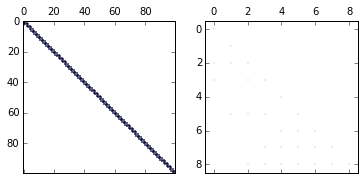

In [71]:
n = 3

ex = np.ones(n);
lp1 = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
e = sp.sparse.eye(n)
A = sp.sparse.kron(lp1, e) + sp.sparse.kron(e, lp1)
A = csc_matrix(A)
T = scipy.sparse.linalg.splu(A)
fig,axes = plt.subplots(1, 2)
axes[0].spy(a,  markersize=1)
axes[1].spy(T.L, marker='.', markersize=0.4)

## Sparse matrices and graph ordering
The number of non-zeros in LU decomposition has a deep connection to the graph theory.  
(I.e., there is an edge between $(i, j)$ if $a_{ij} \ne 0$.

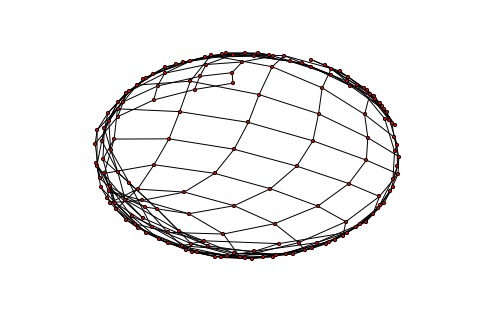

In [36]:
import networkx as nx
n = 13
ex = np.ones(n);
lp1 = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
e = sp.sparse.eye(n)
A = sp.sparse.kron(lp1, e) + sp.sparse.kron(e, lp1)
A = csc_matrix(A)
G = nx.Graph(A)
nx.draw(G, pos=nx.spring_layout(G), node_size=10)

## Strategies for elimination
The reordering that minimizes the fill-in is important, so we can you **graph theory** to find one.

- **Minimum degree ordering** - order by the degree of the vertex
- **Cuthill–McKee algorithm** (and reverse Cuthill-McKee) -- order for a small bandwidth
- **Nested dissection**: split the graph into two with minimal number of vertices on the separator

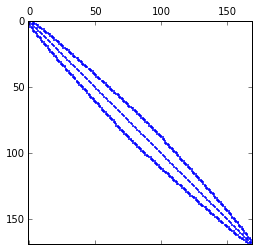

In [38]:
import networkx as nx
from networkx.utils import reverse_cuthill_mckee_ordering, cuthill_mckee_ordering
n = 13
ex = np.ones(n);
lp1 = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
e = sp.sparse.eye(n)
A = sp.sparse.kron(lp1, e) + sp.sparse.kron(e, lp1)
A = csc_matrix(A)
G = nx.Graph(A)
#rcm = list(reverse_cuthill_mckee_ordering(G))
rcm = list(reverse_cuthill_mckee_ordering(G))
A1 = A[rcm, :][:, rcm]
plt.spy(A1, marker='.', markersize=3)
#p, L, U = scipy.linalg.lu(A1.todense())
#plt.spy(L, marker='.', markersize=0.8)
#nx.draw(G, pos=nx.spring_layout(G), node_size=10)

## Florida sparse matrix collection
[Florida sparse matrix collection](http://www.cise.ufl.edu/research/sparse/matrices/) which contains all sorts of matrices for different applications.  It also allows for finding test matrices as well! We can have a look.

In [72]:
from IPython.display import HTML
HTML('<iframe src=http://yifanhu.net/GALLERY/GRAPHS/search.html width=700 height=450></iframe>')

## Test some
Let us check some sparse matrix (and its LU).

In [40]:
fname = 'crystm02.mat'
!wget http://www.cise.ufl.edu/research/sparse/mat/Boeing/$fname

--2015-04-13 17:45:26--  http://www.cise.ufl.edu/research/sparse/mat/Boeing/crystm02.mat
Resolving www.cise.ufl.edu... 128.227.248.40
Connecting to www.cise.ufl.edu|128.227.248.40|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 797624 (779K) [text/plain]
Saving to: 'crystm02.mat.3'

crystm02.mat.3      100%[=====================>] 778.93K   464KB/s   in 1.7s   

2015-04-13 17:45:29 (464 KB/s) - 'crystm02.mat.3' saved [797624/797624]



In [41]:
from scipy.io import loadmat
import scipy.sparse
q = loadmat(fname)
#print q
mat = q['Problem']['A'][0, 0]
T = scipy.sparse.linalg.splu(mat)

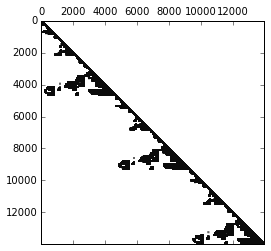

In [42]:
#Compute its LU
%matplotlib inline
import matplotlib.pyplot as plt
plt.spy(T.L, markersize=0.1)

##Iterative solvers

The main disadvantage of factorization methods is there computational complexity.

A more efficient solution of linear systems can be obtained by iterative methods.



This requires **a high rate of convergence** of the iteration to
the exact solution and **low arithmetic cost of each iteration**.

Modern iterative methods are mainly based on idea of iteration on Krylov subspace.

$$ \mathcal{K}_i = span\{b,~Ab,~A^2b,~ ..,~ A^{i-1}b\}, ~~ i = 1,2,..$$
$$ x_i = argmin\{  \|b-Ax\|_2:x\in \mathcal{K}_i\} $$

In fact to apply iterative solver to system with matrix **$~A$** all you need to know is

* how to multiply matrix by vector

* how to apply preconditioner

###Preconditioners

If A is **ill conditioned** then iterative methods gives you **a lot of iterations**.



You can reduce number of iterations if you find matrix **$~B$** (called **preconditioner**), such that   **$~A*B$** or **$~B*A$** matrix has less conditional number.

$$Ax=y \Rightarrow BAx= By$$

$$ABz= y, x= Bz.$$




To be a good preconditioner matrix **$~B$** must  be  somehow close to inverse  matrix of **$~A$**

$$B = A^{-1}$$ 

is perfect preconditioner, it gives you **1** or **2** iterations for convergence.

**But** building this preconditioner requires as much operation as requires  direct solution.

Building preconditioner require some compromise between time for building it and iterations time.

##Two basic strategies for building preconditioner:


* To use information about elements of matrix $A$
 

* To use additional information about problem.

###The first strategy, where we use information about elements of matrix $A$

For sparse matrices we use only non-zero elements.




Good example of this method is to method of **Incomplete matrix factorization**

The main idea here is to avoid full factorization by dropping some steps of it.
Drop rules specific type of incomplete factorization and type of **preconditioner**.

Common types:

* [ILU($0$)](http://en.wikipedia.org/wiki/Incomplete_LU_factorization)
* [ILU(k)](http://en.wikipedia.org/wiki/Incomplete_LU_factorization)
* [ILUt](http://www-users.cs.umn.edu/~saad/PDF/umsi-92-38.pdf)
* [ILU2](https://scholar.google.ru/citations?view_op=view_citation&hl=ru&user=2HaTUbkAAAAJ&citation_for_view=2HaTUbkAAAAJ:u5HHmVD_uO8C)

###The second strategy, where we use additional information about problem.

Here we use knowledge about evaluation of matrix and its special properties. 
For example Multigrid method or Domain Decomposition method (See next lecture)

In [67]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()
